# Reinforcement learning

In [1]:
import gymnasium as gym
import numpy as np
# for allowing abstract methodes (closest thing to interface)
from abc import ABC, abstractmethod
from IPython.display import display, clear_output

class Agent(ABC):

    @abstractmethod
    def _init_weights(self):
        pass

    @abstractmethod
    def copy(self):
        pass

    @abstractmethod
    def get_action(self, observation=None):
        pass

    @abstractmethod
    def mutate(parents=None, mutation_rate=None):
        pass

# simulate single training run
def simulate_env(env, agent):
    observation = env.reset()[0]
    done = False

    total_reward = 0

    while not done:
        # Forward pass through the neural network (manueel geschreven)
        action = agent.get_action(observation)

        # Take the selected action and observe the next state and reward
        observation, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = truncated or terminated

    return total_reward

# train a reinforcment learning agent
def train_agent(env, agent, population_size = 50, mutation_rate=0.4, num_generations = 100, num_episodes=5):

    # Initialize the population
    population = [agent.copy() for _ in range(population_size)]

    # number of generations in the algorithm
    mutation_reduced = False
    best_individual = None
    for generation in range(num_generations):
        scores = []

        # Evaluate each individual in the population
        for current_pop in population:
            total_reward = 0

            # Run multiple episodes to evaluate an individual's performance
            for _ in range(num_episodes):
                total_reward += simulate_env(env, current_pop)

            # Calculate the average score for this individual
            scores.append(total_reward / num_episodes)

        # Select the top-performing individuals
        elite_indices = np.argsort(scores)[-int(0.2 * population_size):]

        # Create a new population by mutating and recombining the elite individuals
        best_individual = population[elite_indices[-1]]
        new_population = [best_individual]  # keep best individual

        while len(new_population) < population_size:

            # pas dit aan -> maak nieuwe agents op basis van een aantal parents
            pass

        population = new_population

        # Print the best score in this generation
        best_score = max(scores)
        if best_score > -100 and not mutation_reduced:
            mutation_rate *= 0.1
            mutation_reduced = True
        print(f"Generation {generation + 1}: Best Score = {best_score}")
    
    # return best individual
    return best_individual

## Genetic algorithms

Dit zijn varianten van evolutionaire algoritmes waarbij gebruik gemaakt wordt van crossover van twee ouders

In [14]:
class GeneticAgent(Agent):
    num_parents = 2
    
    def __init__(self, num_inputs=1, num_outputs=1, hidden_layer_sizes=[]) -> None:
        super().__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_layers_sizes = hidden_layer_sizes
        
        self._init_weights()
        
    def _init_weights(self):
        #print(self.hidden_layers_sizes)
        if len(self.hidden_layers_sizes) == 0:
            self.weights = [np.random.randn(self.num_inputs, self.outputs)]
        else:
            self.weights = []

            for index, hidden_layer in enumerate(self.hidden_layers_sizes):
                if index == 0:
                    self.weights.append(np.random.randn(self.num_inputs, hidden_layer))
                else:
                    self.weights.append(np.random.randn(self.hidden_layers_sizes[index-1], hidden_layer))
                
                if index == len(self.hidden_layers_sizes) -1:
                    self.weights.append(np.random.randn(hidden_layer, self.num_outputs))
                
    def copy(self):
        agent = GeneticAgent(self.num_inputs, self.num_outputs, self.hidden_layers_sizes)
        agent._init_weights()

        return agent
        

    def get_action(self, observation=None):

        action_prob = observation

        for index, hidden_layer in enumerate(self.weights):
            if index == len(self.weights)-1:
                # lineaire activatiefunctie
                action_prob = np.dot(action_prob, hidden_layer)
            else:
                # tanh activatiefunctie
                action_prob = np.tanh(np.dot(action_prob, hidden_layer))

        return np.argmax(action_prob)

    def mutate(self, parents=None, mutation_rate=None):
        if not isinstance(parents, list) and not isinstance(parents[0], GeneticAgent) and not isinstance(parents[1], GeneticAgent):
            return
        
        # voer 2-point crossover uit
        pass
        

In [15]:
# Define the MountainCar environment
env = gym.make("MountainCar-v0")

# Hyperparameters
population_size = 100
mutation_rate = 0.4
num_generations = 100
num_episodes = 5

# RL agent with internally a NN with a hidden layer of 8 neurons
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = GeneticAgent(num_inputs=input_size, num_outputs=output_size, hidden_layer_sizes=[8])

best_genetic_agent = train_agent(env, agent, population_size=population_size, mutation_rate=mutation_rate, num_generations=num_generations, num_episodes=num_episodes)

Generation 1: Best Score = -200.0
Generation 2: Best Score = -200.0
Generation 3: Best Score = -200.0
Generation 4: Best Score = -198.2
Generation 5: Best Score = -200.0
Generation 6: Best Score = -198.2
Generation 7: Best Score = -165.4
Generation 8: Best Score = -165.6
Generation 9: Best Score = -160.8
Generation 10: Best Score = -152.0
Generation 11: Best Score = -177.0
Generation 12: Best Score = -135.4
Generation 13: Best Score = -151.0
Generation 14: Best Score = -143.4
Generation 15: Best Score = -135.0
Generation 16: Best Score = -145.4
Generation 17: Best Score = -122.4
Generation 18: Best Score = -120.4
Generation 19: Best Score = -98.6
Generation 20: Best Score = -110.8
Generation 21: Best Score = -109.8
Generation 22: Best Score = -104.0
Generation 23: Best Score = -110.8
Generation 24: Best Score = -118.0
Generation 25: Best Score = -117.6
Generation 26: Best Score = -110.4
Generation 27: Best Score = -117.4
Generation 28: Best Score = -104.8
Generation 29: Best Score = -1

In [16]:
# Evaluate the best individual
env = gym.make("MountainCar-v0", render_mode="human")

for episode in range(5):
    score = simulate_env(env, best_genetic_agent)
    print(f"Best Individual Score: {score}")

Best Individual Score: -120.0
Best Individual Score: -115.0
Best Individual Score: -88.0
Best Individual Score: -118.0
Best Individual Score: -118.0


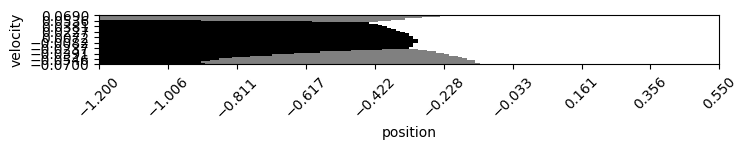

In [22]:
import matplotlib.pyplot as plt

def plot_action_space(agent):

    results = []
    xs = np.arange(-1.2, 0.6, 0.05)
    ys = np.arange(-0.07, 0.07, 0.001)

    for x in xs:
        tmp = []
        for y in ys:
            tmp.append(agent.get_action(np.array([x, y])))
        results.append(tmp)
    results = np.array(results)
    
    plt.figure(figsize=(8, 12))
    plt.imshow(results, cmap='gray', interpolation='none', extent=[xs[0], xs[-1], ys[0], ys[-1]])

    # Add x and y ticks with labels
    plt.xticks(np.linspace(xs[0], xs[-1], num=10), rotation=45)  # Set x-axis ticks
    plt.yticks(np.linspace(ys[0], ys[-1], num=10))                # Set y-axis ticks
    
    # Label the axes
    plt.xlabel('position')
    plt.ylabel('velocity')

plot_action_space(best_genetic_agent)

## Met pytorch

Pas het genetisch algoritme in voorgaande code aan zodat er gebruik gemaakt wordt van pytorch inplaats van de berekeningen manueel met wiskunde operaties te doen.

In [ ]:
# Define the MountainCar environment
env = gym.make("MountainCar-v0")

# Hyperparameters
population_size = 100
mutation_rate = 0.4
num_generations = 100
num_episodes = 5

# RL agent with internally a NN with a hidden layer of 8 neurons
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = GeneticTorchAgent(num_inputs=input_size, num_outputs=output_size, hidden_layer_sizes=[8])

best_genetictorch_agent = train_agent(env, agent, population_size=population_size, mutation_rate=mutation_rate, num_generations=num_generations, num_episodes=num_episodes)

In [ ]:
# Evaluate the best individual
env = gym.make("MountainCar-v0", render_mode="human")

for episode in range(5):
    score = simulate_env(env, best_genetictorch_agent)
    print(f"Best Individual Score: {score}")

In [ ]:
plot_action_space(best_genetictf_agent)